# Radial Basis Function Model

This section supports material covered in the class for radial basis function (RBF) model. In these models, a specific type of basis functions is used which computes similarity between inputs and a set of reference points in the design space. Let $\mathbf{x}$ be the input vector, $\mathbf{c}_i$ be the $i^{th}$ reference point vector, and $r_i$ be the euclidean distance between $\mathbf{x}$ and $\mathbf{c}_i$ i.e. $|| \mathbf{x} - \mathbf{c}_i ||_2$. Then, the basis function vector will be:

$$
    \pmb{\psi} = [ \psi_1(r_1) \quad  \cdots \quad \psi_i(r_i) \quad \cdots \quad \psi_n(r_n)]^T
$$

The reference points are typically training points which implies that number of functions in basis vector will be equal to the number of training points. There are many possible options for $\psi_i(r_i)$ such as:

- Linear: $\psi_i(r_i) = r_i$
- Cubic: $\psi_i(r_i) = r_i^3$
- Thin-plate spline: $\psi_i(r_i) = r_i^2 \log(r_i)$
- Gaussian: $\psi_i(r_i) = \exp (- r_i^2/\sigma^2 )$
- Multiquadric: $\psi_i(r_i) = \sqrt{r_i^2 + \sigma^2}$

where $\sigma$ is a scaling factor. In this section, only gaussian basis function is used.

> __*NOTE*__: The radial basis function model is an interpolating model i.e. the model passes through all the data points. This is very useful when there is no noise in the data but will over-fit easily when there is noise in the data.

`smt` is used for creating RBF models, please refer [documentation](https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/rbf.html) for more details. Below block of code imports required packages:

In [1]:
import numpy as np
from smt.surrogate_models import RBF
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

random_state = 25 # fixes the seed for consistent results

In this notebook, we will be using forrester function (given below) to demonstrate RBF.

$$
y(x) = (6x - 2)^2sin(12x-4) \\
0 \leq x \leq 1
$$

Below block of code defines this function:

In [2]:
forrester = lambda x: (6*x-2)**2*np.sin(12*x-4)

Below block of code defines various variables for the 1d function, and generates training and testing data. Note that unlike polynomial models, training and testing data are generated separately.

In [3]:
# Bounds
xlower = 0
xupper = 1

# Number of training and testing points
num_training_pts = 3
num_testing_pts = 100

# Generating training data
x_train = np.linspace(xlower, xupper, num_training_pts)
y_train = forrester(x_train)

# Generating testing data
x_test = np.linspace(xlower, xupper, num_testing_pts)
y_test = forrester(x_test)

Below block of code fits a RBF to the generated training data. The parameter `d0` controls the value of $\sigma$ in gaussian RBF.

Psi matrix: 
[[1.         0.77880078 0.36787944]
 [0.77880078 1.         0.77880078]
 [0.36787944 0.77880078 1.        ]]

Weights: [ 46.19950846 -86.82440861  66.4528    ]


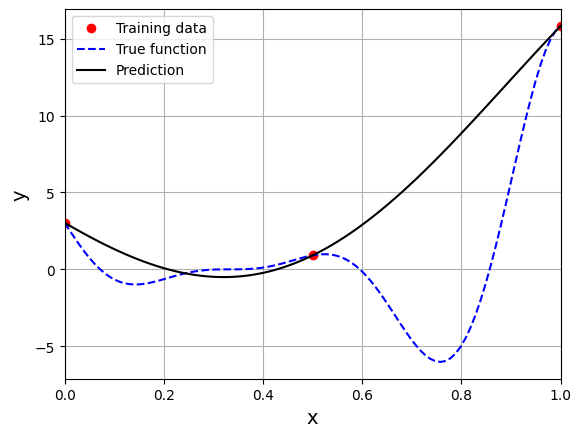

In [4]:
# Fitting the RBF
sm = RBF(d0=1, poly_degree=-1, print_global=False)
sm.set_training_values(x_train, y_train)
sm.train()

print("Psi matrix: \n{}".format(sm.mtx))
print("\nWeights: {}".format(sm.sol[:,0]))

# Predict at test values
y_test_pred = sm.predict_values(x_test)

# Plotting
plt.plot(x_train, y_train, 'ro', label="Training data")
plt.plot(x_test, y_test, 'b--', label="True function")
plt.plot(x_test, y_test_pred, 'k', label="Prediction")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.grid()
plt.show()

The $\Psi$ is a $3 \times 3$ symmetric matrix since there are three training points. Each diagonal element represents similarity of a training point with itself whereas off-diagonal elements represent similarity between two training points. Since we are using gaussian RBF, the diagonal elements are 1. Below block of code defines a function to calculate the value of $\sigma$ using cross-validation. Read comments in the code for more details.

> __*NOTE*__: This method of cross-validation is slightly different from simple or k-fold cross validation described in previous section. There is no need to split training data into k-fold since testing data is already provided.

In [5]:
def find_sigma(x_train, y_train, x_test, y_test, sigmas):
    """
    This function finds the best sigma for a RBF model by fitting the model to the training data and
    evaluating it on testing data. The best sigma is the one that achieves minimum normalized RMSE.

    Parameters
    ----------
    x_train : numpy array
        Training data x values
    y_train : numpy array
        Training data y values
    x_test : numpy array
        Testing data x values
    y_test : numpy array
        Testing data y values
    sigmas : numpy array
        Sigmas to be tested

    Returns
    -------
    best_sigma : float
        Best sigma value
    metric : list
        List of NRMSE values for each sigma
    """

    # Initializing normalized RMSE list
    metric = []

    # Fitting various polynomials
    for sigma in sigmas:

        # Fit the RBF to current fold
        sm = RBF(d0=sigma, poly_degree=-1, print_global=False)
        sm.set_training_values(x_train, y_train)
        sm.train()

        # Predict at test values
        y_pred = sm.predict_values(x_test)

        # Adding all the rmse to calculate average later
        nrmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.ptp(y_test)
            
        # Calculating average nrmse
        metric.append(nrmse)

    best_sigma = sigmas[np.argmin(metric)]

    return best_sigma, metric

Below block of code uses above function to compute the best value of sigma.

Best sigma value found: 0.08497534359086446


Text(0.5, 1.0, 'Variation of NRMSE with $\\sigma$')

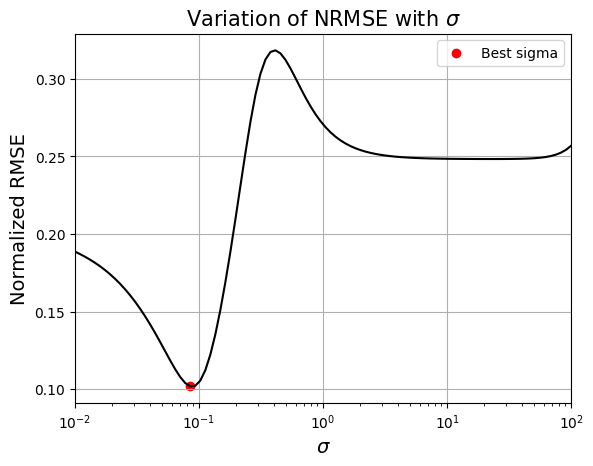

In [6]:
# Creating 1d numpy array which contains sigmas
# Note that it is logspace since values vary from 0.01 to 100
sigmas = np.logspace(-2, 2, 100)

best_sigma, test_metric = find_sigma(x_train, y_train, x_test, y_test, sigmas)

print("Best sigma value found: {}".format(best_sigma))

# Plotting the NRMSE
plt.plot(sigmas, np.array(test_metric), 'k')
plt.scatter(best_sigma, min(test_metric), color='r', label="Best sigma")
plt.xlim((sigmas[0], sigmas[-1]))
plt.xlabel(r"$\sigma$", fontsize=14)
plt.ylabel("Normalized RMSE", fontsize=14)
plt.xscale("log")
plt.grid()
plt.legend()
plt.title(r"Variation of NRMSE with $\sigma$", fontsize=15)

Based on the plot, there a specific value of $\sigma$ for which the rmse is minimum. Next block of code fits RBF model for this value of $\sigma$ and plots the model prediction.

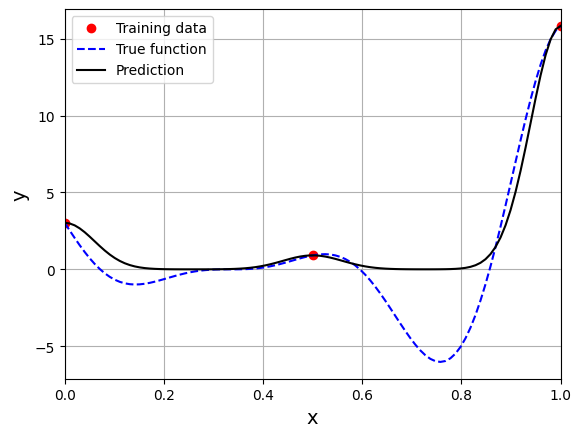

In [8]:
# Fitting the RBF
# d0 is the sigma which controls the spread
# of gaussian basis function
sm = RBF(d0=best_sigma, poly_degree=-1, print_global=False)
sm.set_training_values(x_train, y_train)
sm.train()

# Predict at test values
y_test_pred = sm.predict_values(x_test)

# Plotted the predict values
plt.plot(x_train, y_train, "ro", label="Training data")
plt.plot(x_test, y_test, "b--", label="True function")
plt.plot(x_test, y_test_pred, "k", label="Prediction")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.grid()

This prediction with best $\sigma$ is very different from the earlier prediction using $\sigma = 1.0$ which shows the importance of setting hyperparameters correctly. Now, number of samples will be increased to see when model prediction is good. This method is also known as one-shot sampling. More efficient way to obtain good fit is to use sequential sampling which will be discussed in future sections. Below block of code fits RBF on different sample sizes, plots the fit, and computes normalized rmse.

Best sigma value for 3 samples: 0.08497534359086446
Best sigma value for 4 samples: 0.093260334688322
Best sigma value for 5 samples: 0.10235310218990264
Best sigma value for 6 samples: 0.1484968262254465
Best sigma value for 7 samples: 0.1788649529057435
Best sigma value for 8 samples: 0.1788649529057435
Best sigma value for 9 samples: 0.37649358067924693


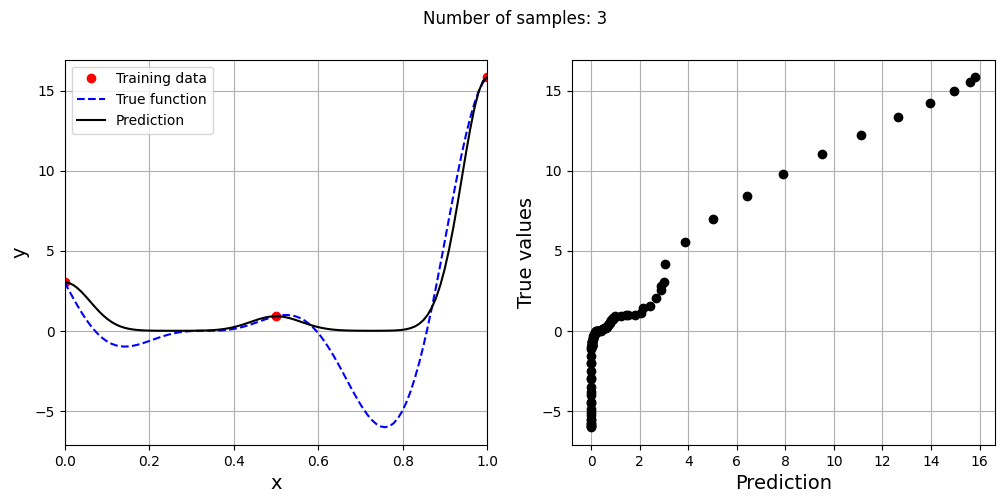

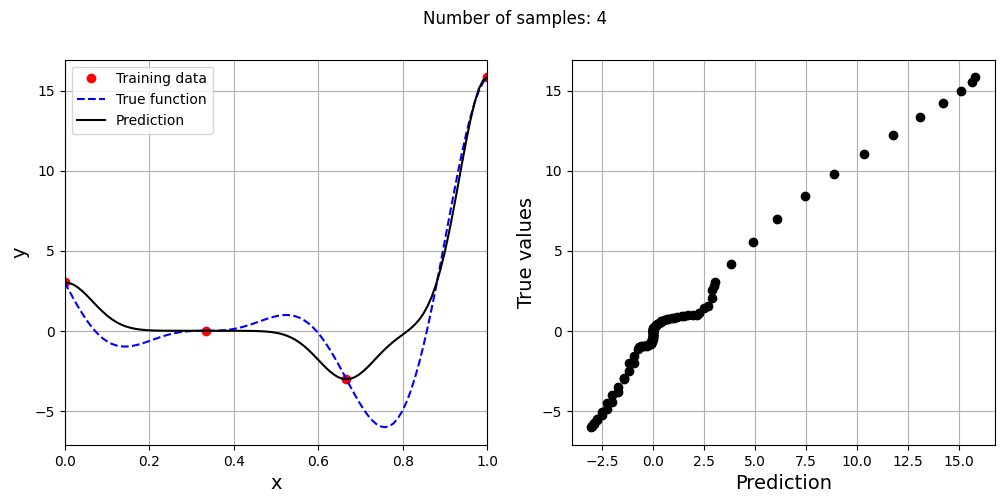

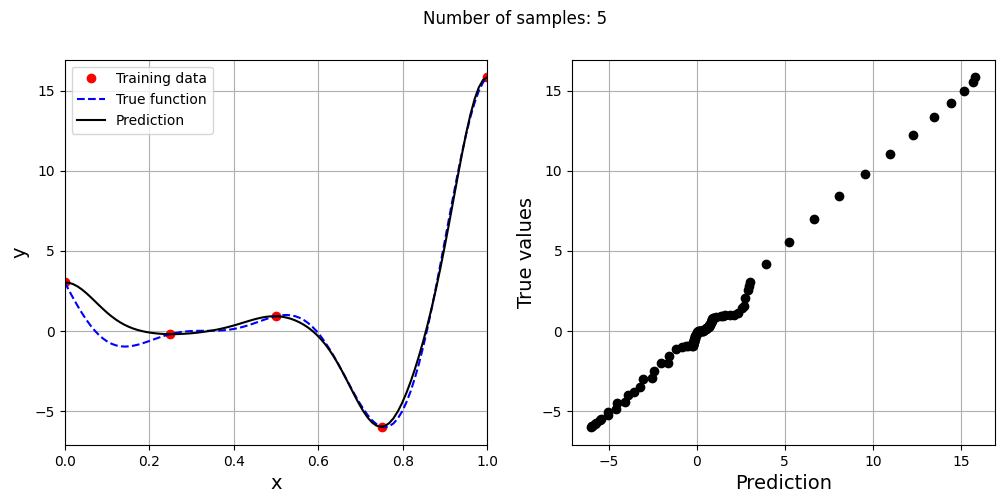

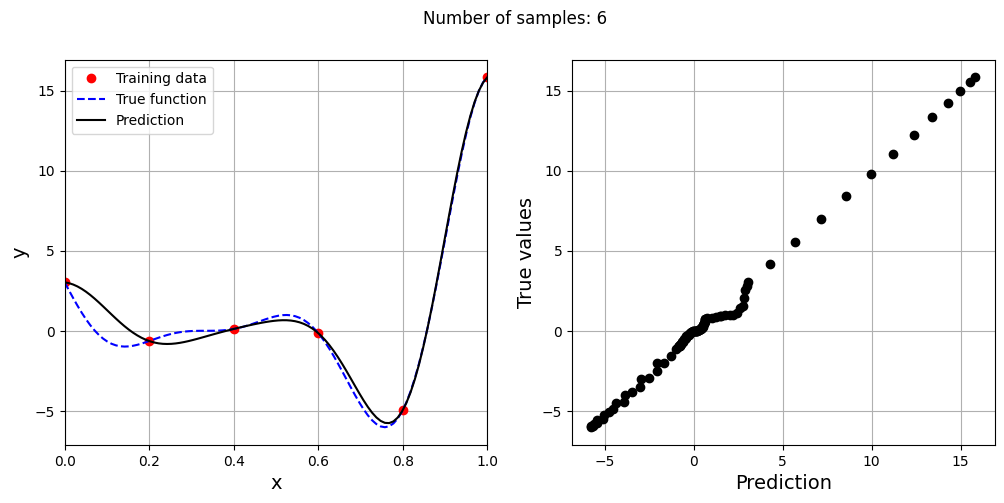

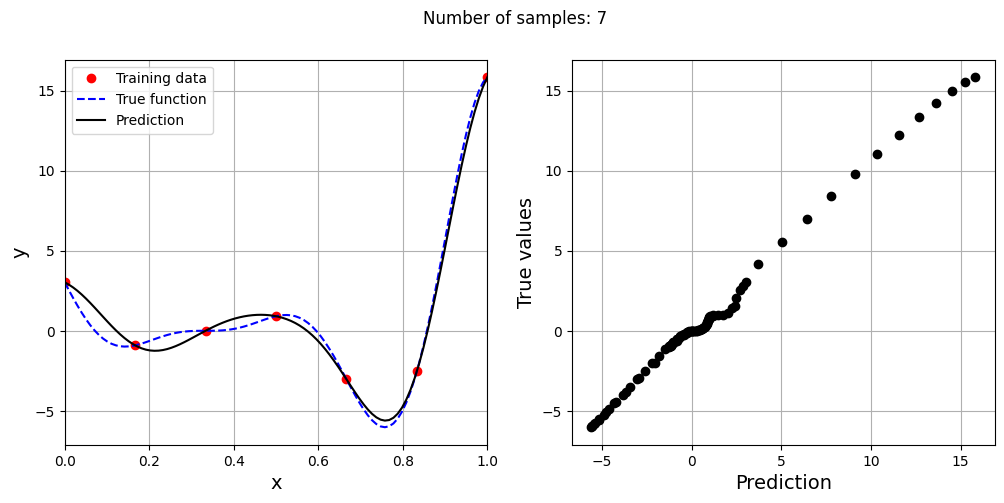

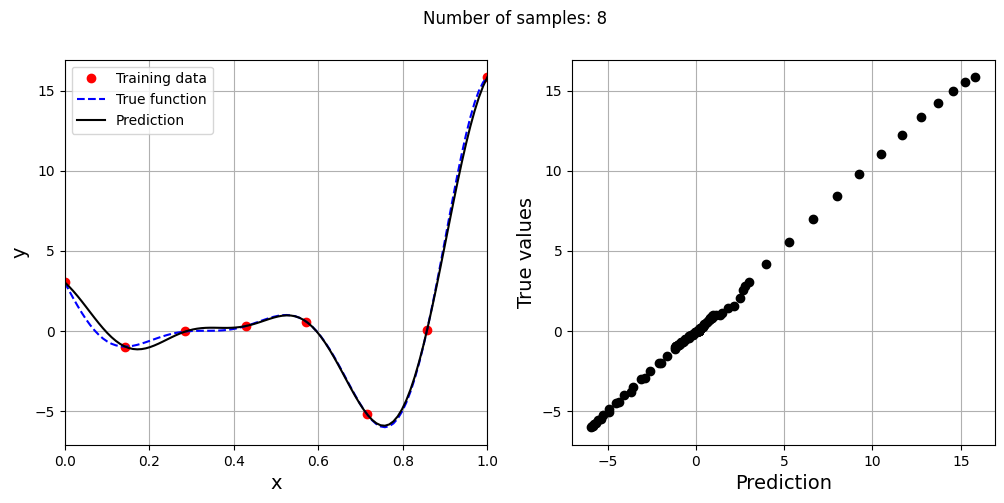

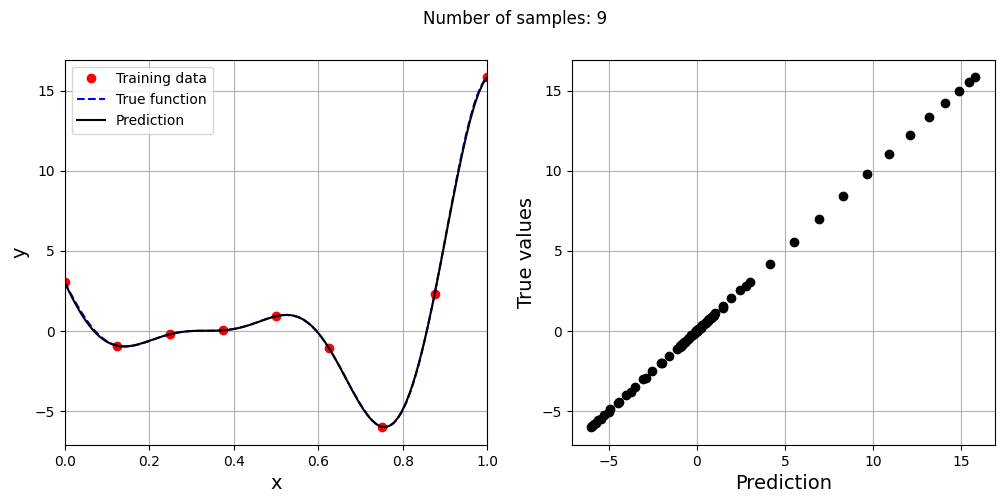

In [9]:
# Creating array of training sample sizes
samples = np.array([3, 4, 5, 6, 7, 8, 9])

# Initializing nrmse list
nrmse = []

sigmas = np.logspace(-2, 2, 100)

# Fitting with different sample size
for sample in samples:
    
    x_train = np.linspace(xlower, xupper, sample)
    y_train = forrester(x_train)
    
    best_sigma, _ = find_sigma(x_train, y_train, x_test, y_test, sigmas)

    print("Best sigma value for {} samples: {}".format(sample, best_sigma))
    
    # Fitting the RBF
    # d0 is the sigma which controls the spread
    # of gaussian basis function
    sm = RBF(d0=best_sigma, poly_degree=-1, print_global=False)
    sm.set_training_values(x_train, y_train)
    sm.train()
    
    # Predict at test values
    y_test_pred = sm.predict_values(x_test).reshape(-1,)

    # Calculating average nrmse
    nrmse.append( np.sqrt(mean_squared_error(y_test, y_test_pred)) / np.ptp(y_test) )
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(x_train, y_train, "ro", label="Training data")
    ax[0].plot(x_test, y_test, "b--", label="True function")
    ax[0].plot(x_test, y_test_pred, "k", label="Prediction")
    ax[0].set_xlim((xlower, xupper))
    ax[0].set_xlabel("x", fontsize=14)
    ax[0].set_ylabel("y", fontsize=14)
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(np.sort(y_test_pred), np.sort(y_test), 'ko')
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

As the number of samples increase, the model prediction becomes better. Also, note that the value of best $\sigma$ changes with number of samples. So, it is important to change the hyperparameters when model is retrained with different data. Below block of code plots the normalized rmse as a function of number of samples. The nrmse decreases as the number of samples increase since prediction improves.

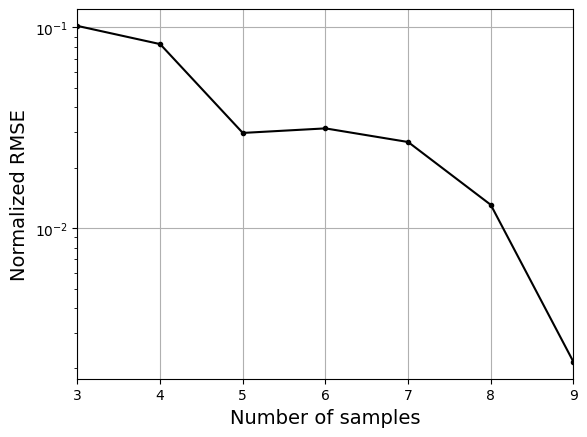

In [53]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), 'k', marker='.')
ax.grid()
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)
ax.set_yscale("log")